In [1]:
import pandas as pd
import seaborn as sns

In [8]:
sns.set()
sns.set_style("whitegrid")

In [65]:
class plant():
    """The plant which produces the good in question.""" 
    
    
    def __init__(self, b=100, c=-10):
        """The __init__ function takes the stable parameters b and c for later use."""
        self.b = b
        self.c = c
    
    def set_b(self, b):
        """Set fixed parameter b"""
        self.b = b
    
    def set_c(self, c):
        """Set fixed parameter c"""
        if c > 0:
            print("Warning: c should be <= 0 for the model to make sense.")
            
        self.c = c
    
    def y_return(self, x):
        """The y_return function returns the y value, that is
        the amount of produced goods."""
        return -(x**2) + self.b*x + self.c
    
    def y_exp_return(self, x, b_exp):
        """The y_exp_return fuction returns the y_exp value, that is
        the *expected* amount ofproduced goods."""
        return -(x**2) + b_exp*x
    
    def U_return(self, y, w, x):
        """The U_return function calculates the utility and the expected utility."""
        return y + w*x
    
    def update_b_exp(self, y, x):
        """The update_b_exp function returns the updated estimation 
        of parameter b i.e. b_exp"""        
        if x != 0: #avoid division by zero
            return y/x + x
        else:
            print("Warning: Division by zero avoided in updating b")
            return y + x # Why this return value?
    
    def update_w(self, x, x_prev, surprise, w):
        """The update_w function returns the updated intrinsic utility
        for using labour for production"""    
        if x != 0: #avoid division by zero
            return (x-x_prev)/abs(x) * surprise / x + w
        else:
            print("Warning: Division by zero avoided in updating w")
            return w # return old value.
    
    def update_x(self, b_exp, w):
        """The update_x function return the amount of labour for production"""
        return (b_exp+w)/2
    
    
    def produce(self, w=0, x=20, b_exp=50, n=10, adapt=False):
        """produce returns a Pandas DataFrame documenting 
        the results of running the plant for n rounds."""
        
       # creating the pandas DataFrame, which will be returned
        index = pd.Index(range(n))
        columns = pd.Index(['w', 'x', 'y', 'y_exp', 'b_exp'])
        data = pd.DataFrame(index=index, columns=columns)
        
        for t in range(n):
            # saving variables
            data['w'][t] = w
            data['x'][t] = x
            data['b_exp'][t] = b_exp
        
            # production and expected production
            data['y'][t] = self.y_return(x)
            data['y_exp'][t] = self.y_exp_return(x, b_exp)
        
            # Utility and expected utility
            U = self.U_return(data['y'][t], w, x)
            U_exp = self.U_return(data['y_exp'][t], w, x)
        
            # updating for next round
            b_exp = self.update_b_exp(data['y'][t], x)
        
            if adapt and t > 0: # w is updated only if adaptive.
                w = self.update_w(data['x'][t], data['x'][t-1],
                                  (U - U_exp), w)
            x = self.update_x(b_exp, w)
            
        # save data from last cycle
        data['w'][-1] = w
        data['x'][-1] = x
        data['b_exp'][-1] = b_exp
    
        return data
    
    def return_y(self, w=0, x=20, b_exp=50, n=50, adapt=False):
        data = self.produce(w, x, b_exp, n, adapt)
        return data['y'][n-1]

For a start, we visualize the difference between the plant without and the plant with adaptive utility using the standard values and varying only parameter c (pilferage).

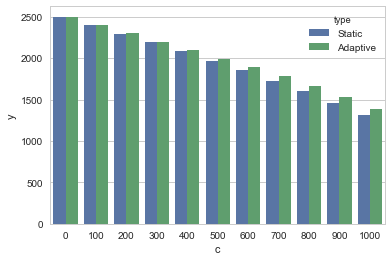

In [66]:
# creating the pandas DataFrame, which will be plotted
index = pd.Index(range(20))
columns = pd.Index(['y', 'c', 'type'])
plot_data = pd.DataFrame(index=index, columns=columns)

# creating our plant
our_plant = plant()

i = 0
for c in range(0, -1100, -100):
    our_plant.set_c(c)
        
    plot_data['c'][i] = abs(c)
    plot_data['y'][i] = our_plant.return_y()
    plot_data['type'][i] = "Static"    
    i += 1
    
    plot_data['c'][i] = abs(c)
    plot_data['y'][i] = our_plant.return_y(adapt=True)
    plot_data['type'][i] = "Adaptive"
    i += 1
    
sns.barplot(x='c', y='y', hue="type", data=plot_data)

As can be seen with the amount of pilferage the plant's output decreases, but the adaptive version does somewhat better.

,y,c,type
0,2500,0,Static
1,2500,0,Adaptive
2,2398.96,100,Static
3,2399.97,100,Adaptive
4,2295.64,200,Static
5,2299.79,200,Adaptive
6,2189.72,300,Static
7,2199.19,300,Adaptive
8,2080.78,400,Static
9,2097.76,400,Adaptive


In [41]:
def show_heatmap(c_values, x_values, b=100):
    heat_plant = plant(b=b)
    
    plot_data = pd.DataFrame(index=x_values,
                         columns=c_values,
                         dtype=float)
    plot_data.index.names = ['x (initial production labour)']
    plot_data.columns.names = ['c (pilferage)']
    
    for c in c_values:
        heat_plant.set_c(c)
        for x in x_values:
            static_y = heat_plant.return_y(x=x, n=5) #took a relatively small n for speed
            adapt_y = heat_plant.return_y(x=x, n=5, adapt=True)

            plot_data[c][x] = adapt_y / static_y
    
    sns.heatmap(plot_data)

In [45]:
def recreate_graphic():
    c_values = [-(b**2)//c_param for c_param in range(15, 65, 5)]
    x_values = [int(b*(x_param/5)) for x_param in range(1, 11)]
    
    show_heatmap(c_values, x_values)

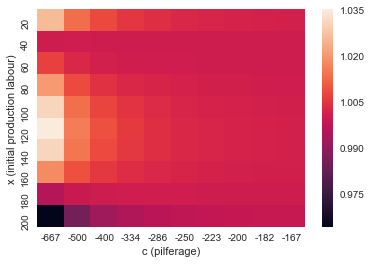

In [46]:
recreate_graphic()

In [47]:
from ipywidgets import widgets

In [63]:
def interactive_map(start_c=-300):
    c_values = [c for c in range(start_c-50*9, start_c+50, 50)]
    x_values = [int(b*(x_param/5)) for x_param in range(1, 11)]
    show_heatmap(c_values, x_values)

In [64]:
widgets.interact(interactive_map, start_c=(-600, 0, 100))

interactive(children=(IntSlider(value=-300, description='start_c', max=0, min=-600, step=100), Output()), _dom…

<function __main__.interactive_map(start_c=-300)>

interactive(children=(IntSlider(value=-300, description='start_c', max=300, min=-900), Output()), _dom_classes…

<function __main__.interactive_map(start_c=-300)>